In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dill
import seaborn as sns

from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost

sns.set()

In [27]:
# Load previously saved preprocessed data splits
with open('../results/data_split_nsr.pkl', 'rb') as file:
    data_split_nsr = dill.load(file)

ftr_names = np.array(['L2 prox gbar', 'L5 prox gbar', 'L2 dist gbar', 'L5 dist gbar', 'Prox variance', 'Dist variance',
               'Prox mean time', 'Dist mean time'])

In [4]:
results_dict = dict()
res_names = ['linear_regression', 'ridge_regression', 'kn_regression']
regression_dict = {
    'linear_regression': LinearRegression,
    'ridge_regression': Ridge,
    'kn_regression': KNeighborsRegressor,
    'sv_regression': SVR,
    'xgb_regression': xgboost.XGBRegressor
}

for name in res_names:
    with open(f'../results/{name}_results.pkl', 'rb') as file:
        results_dict[name] = dill.load(file)

## Linear Regression Coefficients

In [33]:
model_name = 'linear_regression'
split_idx = 0
random_idx = 0

X_train = pd.DataFrame(data_split_nsr[split_idx]['X_train'], columns=ftr_names)
X_test = pd.DataFrame(data_split_nsr[split_idx]['X_test'], columns=ftr_names)
y_train, y_test = data_split_nsr[split_idx]['y_train'],  data_split_nsr[split_idx]['y_test']

reg = regression_dict[model_name]()
params = results_dict[model_name][split_idx][random_idx]['best_params']
reg.set_params(**params)
reg.fit(X_train, y_train)


LinearRegression()

No handles with labels found to put in legend.


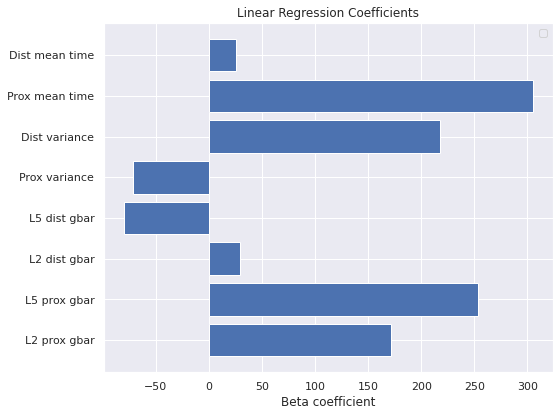

<Figure size 432x288 with 0 Axes>

In [34]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.barh(list(range(n_ftrs)), reg.coef_)
plt.title("Linear Regression Coefficients")
plt.xlabel('Beta coefficient')
plt.yticks(list(range(n_ftrs)), ftr_names)
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig('../figures/linear_regression_coef.png')

## Permutation Test

In [20]:
def permutation_importance(X_test, y_test, reg, ftr_names):
    np.random.seed(42)
    test_score = r2_score(reg.predict(X_test), y_test)

    nr_runs = 10
    scores = np.zeros([len(ftr_names),nr_runs])
    print('test score = ',test_score)
    print('test baseline = ',np.sum(y_test == 0)/len(y_test))
    # loop through the features
    for i in range(len(ftr_names)):
        print('shuffling '+str(ftr_names[i]))
        acc_scores = []
        for j in range(nr_runs):
            X_test_shuffled = X_test.copy()
            X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
            y_pred_shuffled = reg.predict(X_test_shuffled)
            acc_scores.append(r2_score(y_pred_shuffled, y_test))
        print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
        scores[i] = acc_scores

    return scores, test_score

In [35]:
model_name = 'kn_regression'
split_idx = 0
random_idx = 0

X_train = pd.DataFrame(data_split_nsr[split_idx]['X_train'], columns=ftr_names)
X_test = pd.DataFrame(data_split_nsr[split_idx]['X_test'], columns=ftr_names)
y_train, y_test = data_split_nsr[split_idx]['y_train'],  data_split_nsr[split_idx]['y_test']

reg = regression_dict[model_name]()
params = results_dict[model_name][split_idx][random_idx]['best_params']
reg.set_params(**params)
reg.fit(X_train, y_train)


KNeighborsRegressor(n_jobs=4, n_neighbors=12, weights='distance')

In [24]:
scores, test_score = permutation_importance(X_test, y_test, reg, ftr_names)

test score =  0.43412827559666745
test baseline =  0.0
shuffling L2 prox gbar
   shuffled test score: -0.041 +/- 0.011
shuffling L5 prox gbar
   shuffled test score: -0.101 +/- 0.009
shuffling L2 dist gbar
   shuffled test score: 0.163 +/- 0.008
shuffling L5 dist gbar
   shuffled test score: -0.029 +/- 0.013
shuffling Prox variance
   shuffled test score: -0.297 +/- 0.01
shuffling Dist variance
   shuffled test score: -0.141 +/- 0.008
shuffling Prox mean time
   shuffled test score: -0.541 +/- 0.01
shuffling Dist mean time
   shuffled test score: -0.122 +/- 0.012


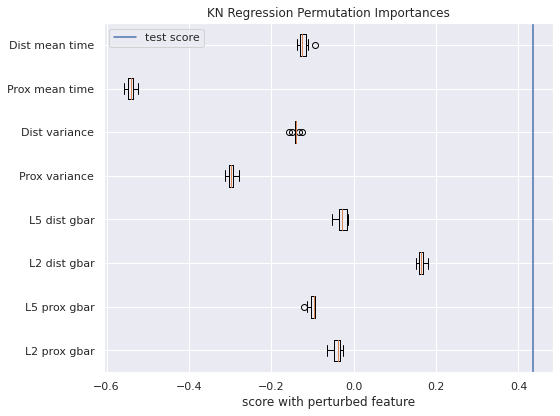

In [36]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores.T,labels=ftr_names,vert=False)
plt.axvline(test_score,label='test score')
plt.title('KN Regression Permutation Importances')
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/kn_regression_permutation.png')

In [ ]:
model_name = 'xgb_regression'
split_idx = 0
random_idx = 0

reg = regression_dict[model_name]()
params = results_dict[model_name][split_idx][random_idx]['best_params']
reg.set_params(**params)
reg.fit(X_train, y_train)

In [ ]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores.T,labels=ftr_names,vert=False)
plt.axvline(test_score,label='test score')
plt.title('XGBoost Regression Permutation Importances')
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/xgb_regression_permutation.png')

## XGBoost Feature Importances

In [ ]:
# model_name = 'xgboost_regression'
# split_idx = 0
# random_idx = 0

# X_train = pd.DataFrame(data_split_nsr[split_idx]['X_train'], columns=ftr_names)
# X_test = pd.DataFrame(data_split_nsr[split_idx]['X_test'], columns=ftr_names)
# y_train, y_test = data_split_nsr[split_idx]['y_train'],  data_split_nsr[split_idx]['y_test']

# reg = regression_dict[model_name]()
# params = results_dict[model_name][split_idx][random_idx]['best_params']
# reg.set_params(**params)
# reg.fit(X_train, y_train)
